In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

In [ ]:
# Step 1: Get S&P 500 Company List
def get_sp500_tickers():
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    sp500_table = pd.read_html(url)[0]  # Get the first table
    sp500_data = sp500_table[['Symbol', 'GICS Sector']]
    sp500_data.columns = ['Ticker', 'Sector']
    return sp500_data

sp500_data = get_sp500_tickers()
print(sp500_data)

    Ticker                  Sector
0      MMM             Industrials
1      AOS             Industrials
2      ABT             Health Care
3     ABBV             Health Care
4      ACN  Information Technology
..     ...                     ...
498    XYL             Industrials
499    YUM  Consumer Discretionary
500   ZBRA  Information Technology
501    ZBH             Health Care
502    ZTS             Health Care

[503 rows x 2 columns]


In [ ]:
# Step 2: Fetch Stock Details
def fetch_stock_details(tickers):
    stock_data = []
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            info = stock.info
            stock_data.append({
                'Ticker': ticker,
                'Name': info.get('longName', 'N/A'),
                'Sector': info.get('sector', 'N/A'),
                'Market Cap': info.get('marketCap', 'N/A'),
                'Current Price': info.get('currentPrice', 'N/A'),
                'PE Ratio': info.get('trailingPE', 'N/A'),
                'Dividend Yield': info.get('dividendYield', 'N/A'),
            })
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
    return pd.DataFrame(stock_data)

tickers = sp500_data['Ticker'].tolist()

# Fetch stock details for the S&P 500 companies
stock_details = fetch_stock_details(tickers)

# Display first few rows of the data
print(stock_details)

# Save to CSV for further analysis
stock_details.to_csv("sp500_stock_details.csv", index=False)

    Ticker                            Name             Sector    Market Cap  \
0      MMM                      3M Company        Industrials   70852567040   
1      AOS         A. O. Smith Corporation        Industrials    9932157952   
2      ABT             Abbott Laboratories         Healthcare  196124065792   
3     ABBV                     AbbVie Inc.         Healthcare  315134083072   
4      ACN                   Accenture plc         Technology  219599765504   
..     ...                             ...                ...           ...   
498    XYL                      Xylem Inc.        Industrials   28489504768   
499    YUM               Yum! Brands, Inc.  Consumer Cyclical   37796671488   
500   ZBRA  Zebra Technologies Corporation         Technology   20202854400   
501    ZBH    Zimmer Biomet Holdings, Inc.         Healthcare   21095872512   
502    ZTS                     Zoetis Inc.         Healthcare   74112876544   

    Current Price   PE Ratio Dividend Yield  
0    

[*********************100%***********************]  10 of 10 completed


Best Parameters: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 50}

Portfolio Allocation:
  Ticker        Weight
0   AAPL  0.000000e+00
1   MSFT  1.792000e-01
2  GOOGL  0.000000e+00
3   AMZN  9.077076e-17
4   TSLA  1.275043e-17
5    JNJ  0.000000e+00
6    XOM  8.005300e-01
7      V  0.000000e+00
8     PG  1.431502e-16
9   NVDA  2.026997e-02


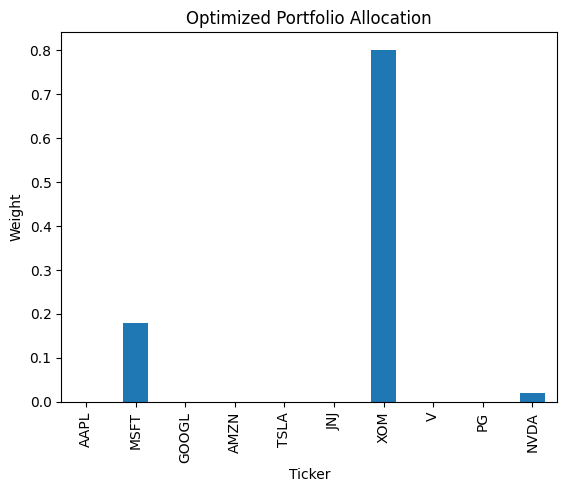

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Step 1: Fetch Historical Stock Data
def get_stock_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)
    return data['Adj Close']

# Step 2: Feature Engineering
def create_features(data):
    returns = data.pct_change().dropna()  # Calculate percentage change
    features = pd.DataFrame(index=returns.index)

    # Add rolling mean, volatility, and momentum for each stock as features
    for column in returns.columns:
        features[f'{column}_Mean_Return_10d'] = returns[column].rolling(10).mean()
        features[f'{column}_Volatility_10d'] = returns[column].rolling(10).std()
        features[f'{column}_Momentum_10d'] = returns[column].rolling(10).sum()

    # Add moving averages
    for column in data.columns:
        features[f'{column}_SMA_50'] = data[column].rolling(50).mean()
        features[f'{column}_SMA_200'] = data[column].rolling(200).mean()

    # Drop rows with NaN values created by rolling operations
    features.dropna(inplace=True)

    # Future returns as targets (ensure index alignment with features)
    future_returns = returns.shift(-1).reindex(features.index)

    # Drop rows with NaN values in the target
    valid_indices = ~future_returns.isnull().any(axis=1)
    features = features.loc[valid_indices]
    future_returns = future_returns.loc[valid_indices]

    return features, future_returns

# Step 3: Train Machine Learning Model
def train_advanced_model(X, y):
    model = RandomForestRegressor(random_state=42)

    # Hyperparameter tuning using Grid Search
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5, 10]
    }
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_

    print("Best Parameters:", grid_search.best_params_)
    return best_model

# Step 4: Portfolio Optimization
def optimize_portfolio(expected_returns, cov_matrix):
    num_assets = len(expected_returns)

    def objective(weights):
        portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
        portfolio_return = np.dot(weights, expected_returns)
        # Minimize -Sharpe Ratio (maximize return and minimize risk)
        return -portfolio_return / np.sqrt(portfolio_variance)

    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))  # No short-selling
    initial_weights = np.ones(num_assets) / num_assets

    result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Main Execution
start_date = '2020-01-01'
end_date = '2023-01-01'

# Example: Limit to 10 S&P 500 tickers for simplicity
sp500_tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'JNJ', 'XOM', 'V', 'PG', 'NVDA']
data = get_stock_data(sp500_tickers, start_date, end_date)

# Step 2: Prepare features and target
features, future_returns = create_features(data)

# Ensure no NaN in features or target
X = features.values
y = future_returns.mean(axis=1)  # Use the mean of future returns as a single target value

# Drop any remaining NaN values in y
valid_indices = ~np.isnan(y)
X = X[valid_indices]
y = y[valid_indices]

# Step 3: Train the model
model = train_advanced_model(X, y)

# Step 4: Predict future returns
predicted_returns = model.predict(X)

# Aggregate predicted returns by stock (mean of predictions per stock)
num_stocks = len(sp500_tickers)
aggregated_returns = np.zeros(num_stocks)
block_size = X.shape[1] // num_stocks  # Block size per stock

for i in range(num_stocks):
    aggregated_returns[i] = predicted_returns[i::block_size].mean()

# Step 5: Covariance matrix for portfolio optimization
cov_matrix = data.pct_change().cov()

# Step 6: Optimize portfolio weights
weights = optimize_portfolio(aggregated_returns, cov_matrix)

# Display Results
allocation = pd.DataFrame({'Ticker': sp500_tickers, 'Weight': weights})
print("\nPortfolio Allocation:")
print(allocation)

# Save allocation to a CSV file
allocation.to_csv("optimized_sp500_portfolio.csv", index=False)

# Visualize Allocation
allocation.plot(kind='bar', x='Ticker', y='Weight', legend=False, title='Optimized Portfolio Allocation')
plt.ylabel('Weight')
plt.show()
